In [1]:
batch_size = 128
learning_rate = 1e-3
epochs = 5
logging_freqency = 100  # number of steps before print and save (to plot) policy/value loss
checkpoint_frequency = 3000

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

from dinora.models.torchnet.network import NeuralNetwork

c:\Users\Saegl\projects\python\dinora\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if not torch.cuda.is_available():
    raise Exception("Cuda is not available!")

device = "cuda"
print(f"Using {device} device")

Using cuda device


In [4]:
from dinora.dataset2 import download_ccrl_dataset
from torch.utils.data import DataLoader

train_data, test_data = download_ccrl_dataset()

# You can use your own pgns instead
# Ex:
# from dinora.dataset2 import PGNDataset
#
# train_data = PGNDataset("path/to/my/train.pgn")
# test_data = PGNDatset("path/to/my/test.pgn")


train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


# Just a simple data check
for x, (y_policy, y_value) in train_dataloader:
    print("x:", x.dtype, x.shape)
    print("y_policy:", y_policy.dtype, y_policy.shape)
    print("y_value:", y_value.dtype, y_value.shape)

    print("First game in dataset ended with a ", end='')
    if y_value[0].item() == 0.0:
        print("draw")
    elif y_value[0].item() == 1.0:
        print("white won")
    elif y_value[0].item() == -1.0:
        print("black won")
    else:
        raise ValueError("Wrong game result")
    break


CCRL already downloaded
Extracted games found
x: torch.float32 torch.Size([128, 18, 8, 8])
y_policy: torch.float32 torch.Size([128, 1880])
y_value: torch.float32 torch.Size([128, 1])
First game in dataset ended with a draw


In [5]:
model = NeuralNetwork().to(device)
print(model)


policy_loss_fn = nn.CrossEntropyLoss()
value_loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1152, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=2048, bias=True)
  )
  (policy_output): Sequential(
    (0): Linear(in_features=2048, out_features=1880, bias=True)
    (1): Softmax(dim=-1)
  )
  (value_output): Sequential(
    (0): Linear(in_features=2048, out_features=1, bias=True)
    (1): Tanh()
  )
)


In [6]:
def train(
    epoch: int,
    dataloader: DataLoader,
    model: nn.Module,
    policy_loss_fn: nn.CrossEntropyLoss,
    value_loss_fn: nn.MSELoss,
    optimizer: torch.optim.Optimizer,
    logging_frequency: int,
    checkpoint_frequency: int,
    policy_losses: list[float],
    value_losses: list[float],
):
    model.train()
    for batch, (X, (y_policy, y_value)) in tqdm(enumerate(dataloader)):
        X, (y_policy, y_value) = X.to(device), (y_policy.to(device), y_value.to(device))

        # Compute prediction error
        policy_pred, value_pred = model(X)
        policy_loss = policy_loss_fn(policy_pred, y_policy)
        value_loss = value_loss_fn(value_pred, y_value)

        # Backpropagation
        optimizer.zero_grad()
        loss = policy_loss + value_loss
        loss.backward()
        optimizer.step()

        if batch % logging_frequency == 0:
            policy_loss = policy_loss.item()
            value_loss = value_loss.item()
            current = batch * len(X)
            policy_losses.append(policy_loss)
            value_losses.append(value_loss)
            print(
                f"\n\n policy_loss: {policy_loss:>7f} value_loss: {value_loss:>7f}"
                f"\n [states: {current:>5d}]\n"
            )
        
        # (batch + 1) - Don't checkpoint after first batch
        if (batch + 1) % checkpoint_frequency == 0:
            torch.save(model.state_dict(), f'model-{epoch}-{batch + 1}.pth')


def test(
    dataloader,
    model,
    policy_loss_fn: nn.CrossEntropyLoss,
    value_loss_fn: nn.MSELoss,
):
    model.eval()
    policy_loss = 0.0
    value_loss = 0.0
    policy_correct = 0

    with torch.no_grad():
        for num, (X, (y_policy, y_value)) in tqdm(enumerate(dataloader)):
            X, (y_policy, y_value) = X.to(device), (
                y_policy.to(device),
                y_value.to(device),
            )

            policy_pred, value_pred = model(X)
            policy_loss += policy_loss_fn(policy_pred, y_policy).item()
            value_loss += value_loss_fn(value_pred, y_value).item()
            policy_correct += (
                (policy_pred.argmax(1) == y_policy.argmax(1))
                .type(torch.float)
                .sum()
                .item()
            )

    num_batches = num + 1
    size = num_batches * batch_size

    policy_loss /= num_batches
    policy_correct /= size
    value_loss /= num_batches

    print(
        f"Test Error: \n Policy accuracy: {(100*policy_correct):>0.1f}%, Policy loss: {policy_loss:>8f}, Value loss: {value_loss:>8f} \n"
    )

In [7]:
policy_losses = []
value_losses = []


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(
        t,
        train_dataloader,
        model,
        policy_loss_fn,
        value_loss_fn,
        optimizer,
        logging_freqency,
        checkpoint_frequency,
        policy_losses,
        value_losses,
    )
    test(test_dataloader, model, policy_loss_fn, value_loss_fn)
print("training done")

Epoch 1
-------------------------------


5it [00:02,  2.35it/s]



 policy_loss: 7.539024 value_loss: 0.133869
 [states:     0]



106it [00:05, 39.05it/s]



 policy_loss: 7.523798 value_loss: 0.991393
 [states: 12800]



207it [00:08, 34.82it/s]



 policy_loss: 7.523400 value_loss: 0.101730
 [states: 25600]



304it [00:11, 35.44it/s]



 policy_loss: 7.523404 value_loss: 0.971112
 [states: 38400]



405it [00:14, 35.26it/s]



 policy_loss: 7.538569 value_loss: 0.986140
 [states: 51200]



504it [00:16, 29.71it/s]



 policy_loss: 7.496520 value_loss: 0.887281
 [states: 64000]



606it [00:19, 36.28it/s]



 policy_loss: 7.508286 value_loss: 0.321962
 [states: 76800]



705it [00:22, 36.17it/s]



 policy_loss: 7.509590 value_loss: 0.354670
 [states: 89600]



807it [00:25, 40.68it/s]



 policy_loss: 7.520094 value_loss: 0.423164
 [states: 102400]



904it [00:27, 35.33it/s]



 policy_loss: 7.516718 value_loss: 0.899575
 [states: 115200]



1007it [00:30, 36.43it/s]



 policy_loss: 7.516717 value_loss: 0.961784
 [states: 128000]



1104it [00:33, 35.01it/s]



 policy_loss: 7.516548 value_loss: 0.974378
 [states: 140800]



1206it [00:36, 32.34it/s]



 policy_loss: 7.539866 value_loss: 0.001744
 [states: 153600]



1307it [00:39, 34.96it/s]



 policy_loss: 7.532050 value_loss: 0.770828
 [states: 166400]



1404it [00:42, 39.56it/s]



 policy_loss: 7.485194 value_loss: 0.244315
 [states: 179200]



1505it [00:44, 37.63it/s]



 policy_loss: 7.524266 value_loss: 0.466035
 [states: 192000]



1606it [00:47, 34.50it/s]



 policy_loss: 7.508653 value_loss: 0.976853
 [states: 204800]



1708it [00:50, 36.88it/s]



 policy_loss: 7.477832 value_loss: 0.907228
 [states: 217600]



1808it [00:53, 36.12it/s]



 policy_loss: 7.532141 value_loss: 0.017385
 [states: 230400]



1908it [00:56, 34.54it/s]



 policy_loss: 7.520244 value_loss: 1.778506
 [states: 243200]



2005it [00:59, 32.78it/s]



 policy_loss: 7.516950 value_loss: 1.314529
 [states: 256000]



2104it [01:02, 35.04it/s]



 policy_loss: 7.532118 value_loss: 2.053942
 [states: 268800]



2209it [01:04, 41.70it/s]



 policy_loss: 7.516164 value_loss: 1.547768
 [states: 281600]



2307it [01:07, 37.47it/s]



 policy_loss: 7.524311 value_loss: 1.677870
 [states: 294400]



2405it [01:10, 28.60it/s]



 policy_loss: 7.524300 value_loss: 1.440557
 [states: 307200]



2504it [01:13, 32.03it/s]



 policy_loss: 7.524311 value_loss: 0.738319
 [states: 320000]



2605it [01:16, 31.47it/s]



 policy_loss: 7.524314 value_loss: 1.056981
 [states: 332800]



2677it [01:18, 34.14it/s]


KeyboardInterrupt: 

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Saegl\\projects\\python\\dinora\\.venv\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Saegl\\projects\\python\\dinora\\.venv\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Saegl\\projects\\python\\dinora

Policy loss


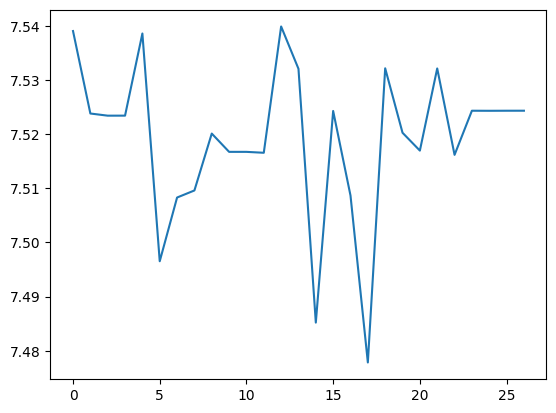

In [8]:
print("Policy loss")
plt.plot(policy_losses)

Value loss


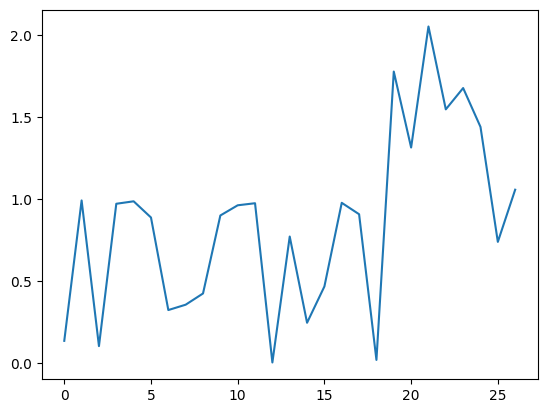

In [9]:
print("Value loss")
plt.plot(value_losses)

In [10]:
model_filename = f"model.pth"
torch.save(model.state_dict(), model_filename)

print(f"Model saved as '{model_filename}'")

Model saved as 'model.pth'
